In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/muef/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

### importing data

In [2]:
run_qs = RunStats.objects.filter(psearch__id=89, method="BD", status=3)

pd.DataFrame.from_dict(run_qs.values('run_id', 'coherence', 'exclusivity', 'K', 'alpha',
                                'top_chain_var', 'rng_seed', 'max_iter'))

,K,alpha,coherence,exclusivity,max_iter,rng_seed,run_id,top_chain_var
0,40,0.01,0.396576,0.730940,200,1,2354,0.050
1,40,0.01,0.445240,0.829526,200,1,2362,0.020
2,40,0.05,0.397664,0.738769,200,1,2366,0.050
3,40,0.05,0.467016,0.869076,200,1,2353,0.010
4,40,0.02,0.461092,0.861722,200,1,2363,0.010
5,35,0.01,0.419955,0.804016,200,1,2350,0.010
6,40,0.01,0.458939,0.868018,200,1,2351,0.010
7,45,0.01,0.480687,0.928956,200,1,2352,0.010
8,45,0.05,0.473385,0.912385,50,1,2156,0.010
9,45,0.01,0.464178,0.878157,50,1,2155,0.010


In [2]:
run_id = 2350
# for ISIE talk: run_id = 1749

save_dir = "./plots/topic_analysis_{}/time+party/".format(run_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

### Party Analysis

In [5]:
topic_id = 177242
topic_label = Topic.objects.get(id=topic_id).title
t1_party_totals = pm.Utterance.objects.filter(
    doctopic__topic__run_id=run_id, 
    speaker__party__name__isnull=False,
    speaker__party__colour__isnull=False
).order_by().values('speaker__party__name','document__parlperiod__n').annotate(
    topic_score=Sum(
        Case(
            When(doctopic__topic=topic_id,
                 then=F('doctopic__score')),
            default=0,
            output_field=models.FloatField()
        )),
    total_score=Sum('doctopic__score'),
).annotate(topic_proportion=F('topic_score') / F('total_score')).values(
    'document__parlperiod__n', #parlperiod
    'topic_score', #doctopicscore
    'total_score',
    'topic_proportion',
    'speaker__party__id',
    'speaker__party__name',
    'speaker__party__colour'
).order_by('-document__parlperiod__n')

dft = pd.DataFrame.from_dict(list(t1_party_totals))
dft

NameError: name 'topic_id' is not defined

In [3]:
# from parliament/views.py

# note: speaker__party__colour__isnull=False prevents loading data for other parties

def get_table_for_party_plots(topic_id):
    
    topic_label = Topic.objects.get(id=topic_id).title
    t1_party_totals = pm.Utterance.objects.filter(
        doctopic__topic__run_id=run_id, 
        speaker__party__name__isnull=False,
        speaker__party__colour__isnull=False
    ).order_by().values('speaker__party__name','document__parlperiod__n').annotate(
        topic_score=Sum(
            Case(
                When(doctopic__topic=topic_id,
                     then=F('doctopic__score')),
                default=0,
                output_field=models.FloatField()
            )),
        total_score=Sum('doctopic__score'),
    ).annotate(topic_proportion=F('topic_score') / F('total_score')).values(
        'document__parlperiod__n', #parlperiod
        'topic_score', #doctopicscore
        'total_score',
        'topic_proportion',
        'speaker__party__id',
        'speaker__party__name',
        'speaker__party__colour'
    ).order_by('-document__parlperiod__n')
    
    dft = pd.DataFrame.from_dict(list(t1_party_totals))
    dft.columns = ['parlperiod', 'party_colour', 'party_id', 'party_name', 'doctopic_proportion', 'doctopic_score', 'total_doctopic_score']
    dft_score = pd.DataFrame([dft['parlperiod'], dft['party_name'], dft['doctopic_score']]).transpose()
    dft_score = dft_score.pivot(index='parlperiod', columns='party_name', values='doctopic_score')
    
    dft_proportion = pd.DataFrame([dft['parlperiod'], dft['party_name'], dft['doctopic_proportion']]).transpose()
    dft_proportion = dft_proportion.pivot(index='parlperiod', columns='party_name', values='doctopic_proportion')
    
    return dft_score, dft_proportion

In [5]:
# Stacked bar plot scores
def stacked_bar_plot_party(df, topic_label, filename="", pct=False, value_name="DocTopic score"):
    
    if pct:
        df_plot = df.copy()
        for i in df_plot.index:
            df_plot.loc[i] = df_plot.loc[i] / df_plot.loc[i].sum() * 100
        ylabel = '% of {}'.format(value_name)
        title_str = "Percentage of {} per party for '{}'".format(value_name, topic_label)
    
    else:
        ylabel = value_name
        title_str = "{} per party for '{}'".format(value_name, topic_label)
        df_plot = df
        
    ax = df_plot.plot(kind='bar', stacked=True, # title=topic_names[0],
                     figsize=(10,8), xticks = df_plot.index)
    
    ax.set(xlabel='Parliamentary Period', ylabel=ylabel, title=title_str)
    
    if pct:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        plt.legend(title="")
        
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")


# Stacked bar plot percent scores
def stacked_bar_plot_party_scores_pct_of_all(df, df_scores, topic_label, filename=""):
    
    dft_shares = df.copy()
    for i in dft_shares.index:
        dft_shares.loc[i] = dft_shares.loc[i] / df_scores.loc[i].sum() * 100

    ax = dft_shares.plot(kind='bar', stacked=True, # title=topic_names[0],
                     figsize=(10,8), xticks = dft_shares.index)
    ax.set(xlabel='Parliamentary Period', ylabel='% of total topic scores', title="{}".format(topic_label))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.legend(title="")

    fig = plt.gcf()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")


# manual setting of colour, needs to be adjusted with new party or order change 
party_colour = ["#0088FF", "#000000", "#FFED00", "#64A12D", "#8C3473", "#EB001F"]
sns.set_palette(party_colour)
sns.set_context('talk')

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


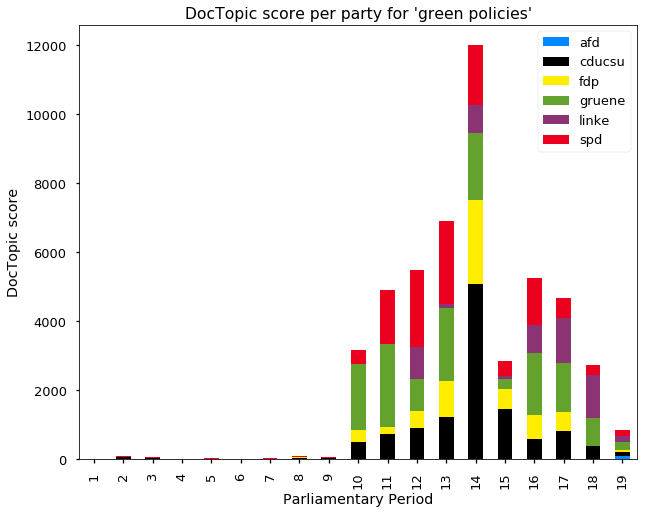

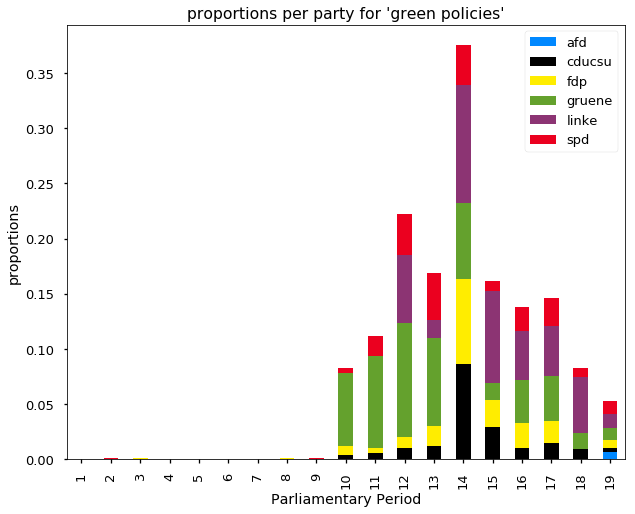

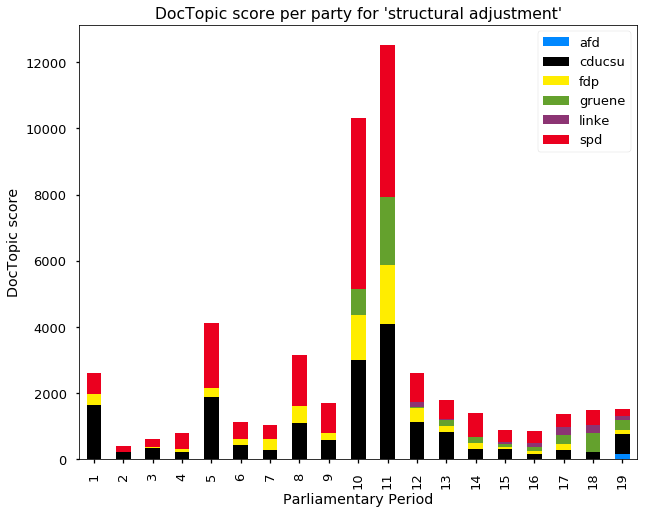

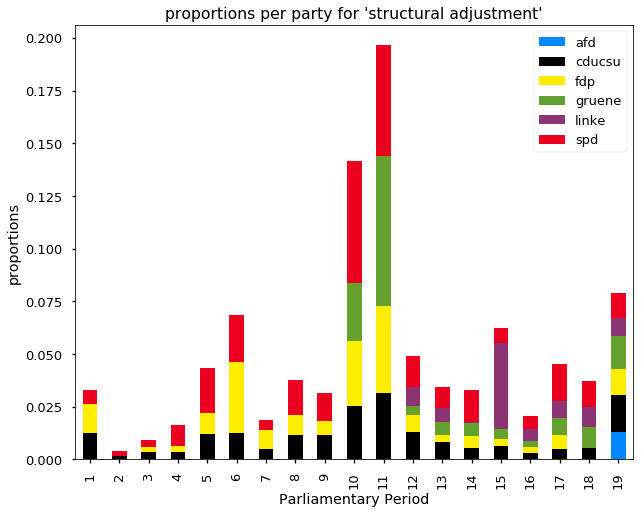

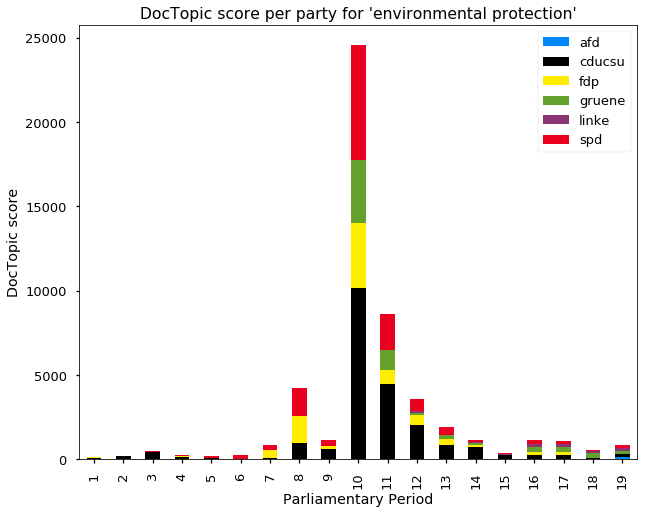

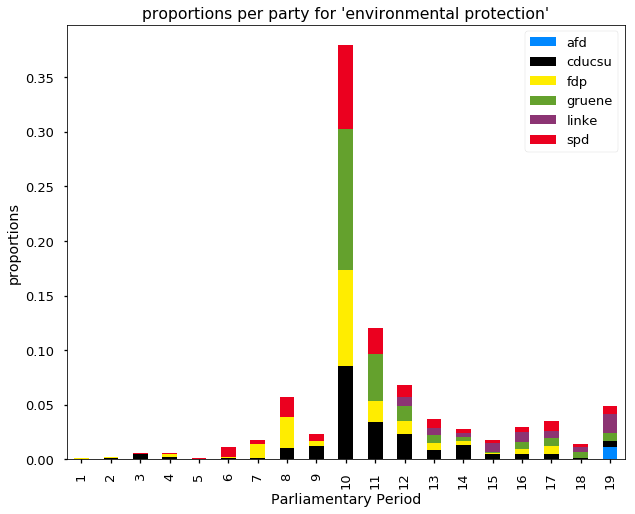

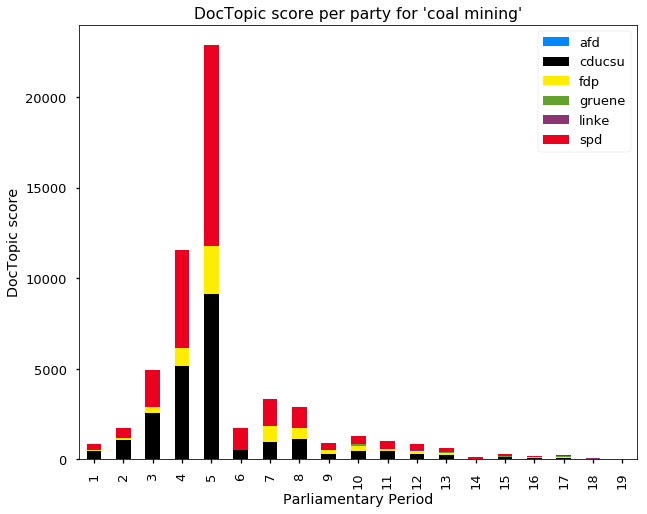

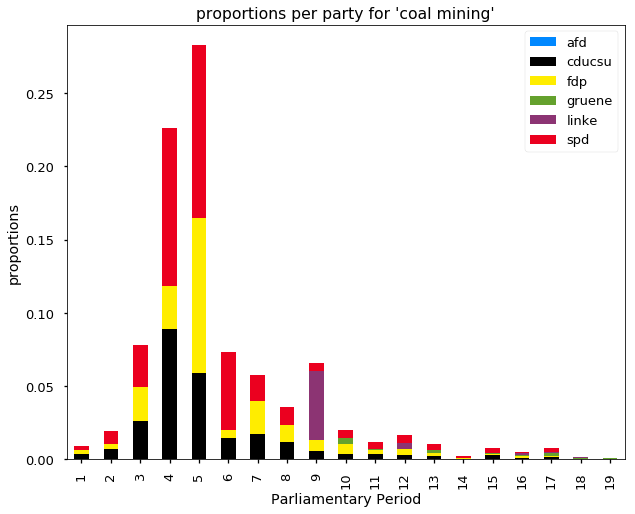

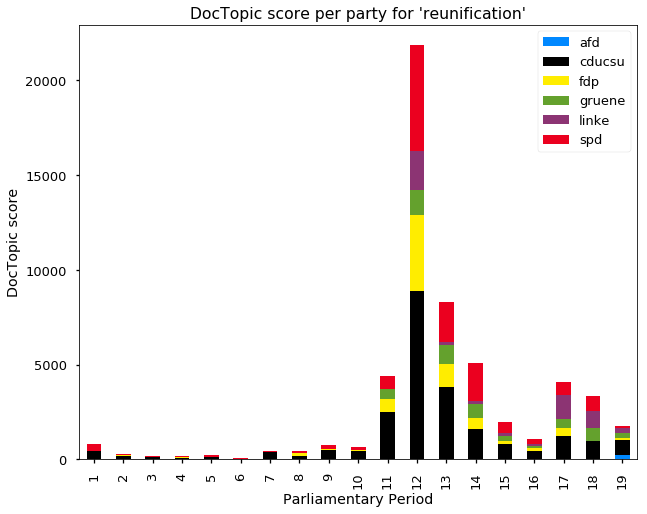

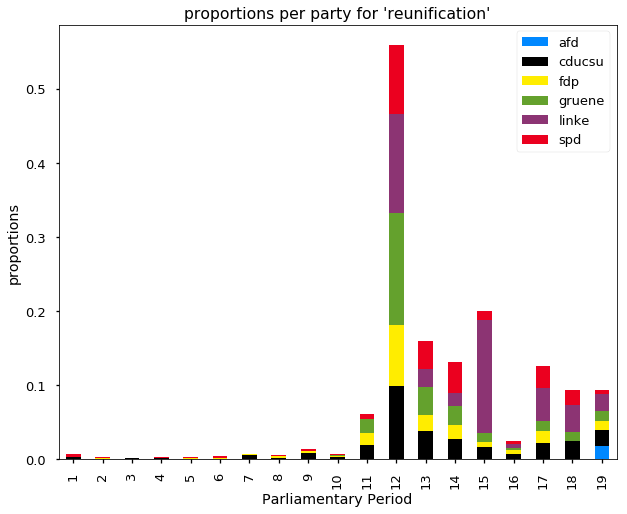

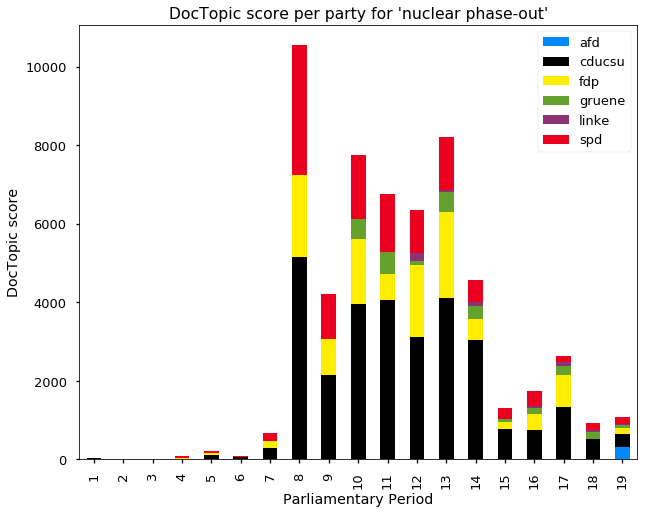

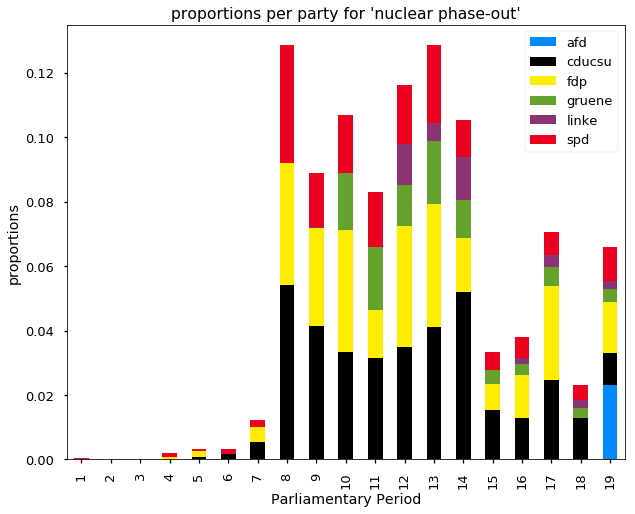

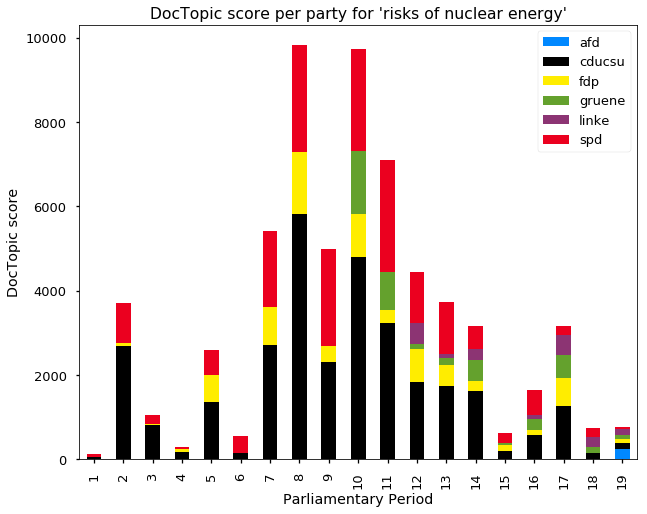

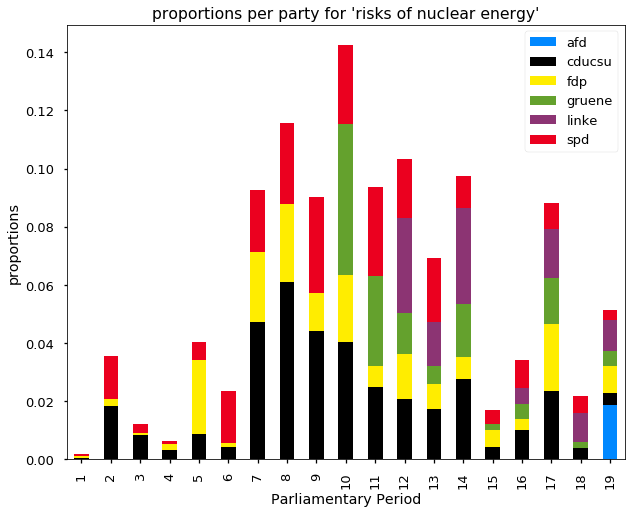

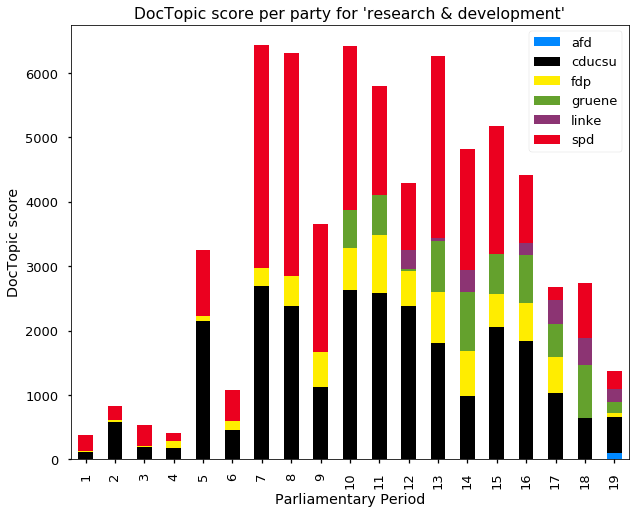

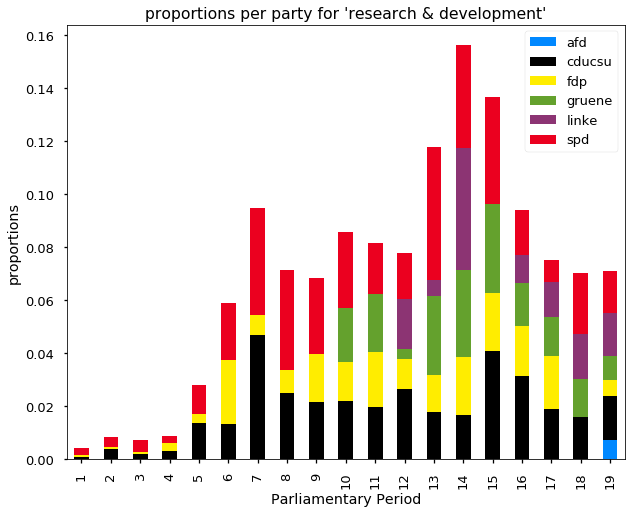

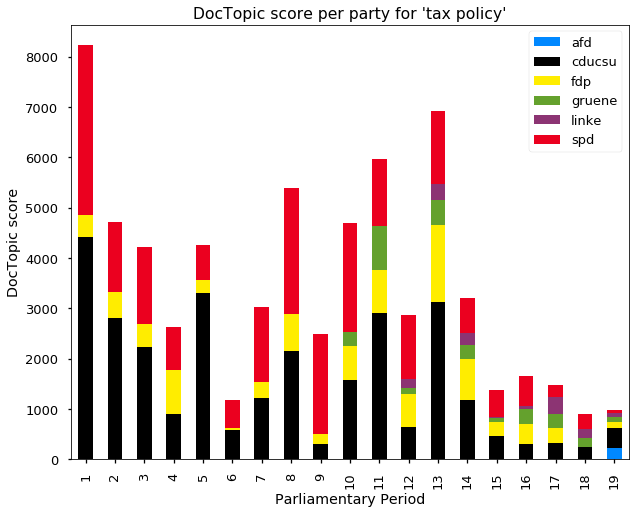

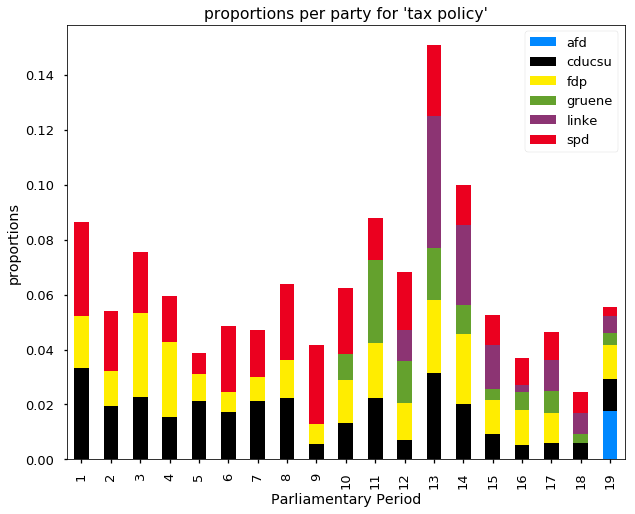

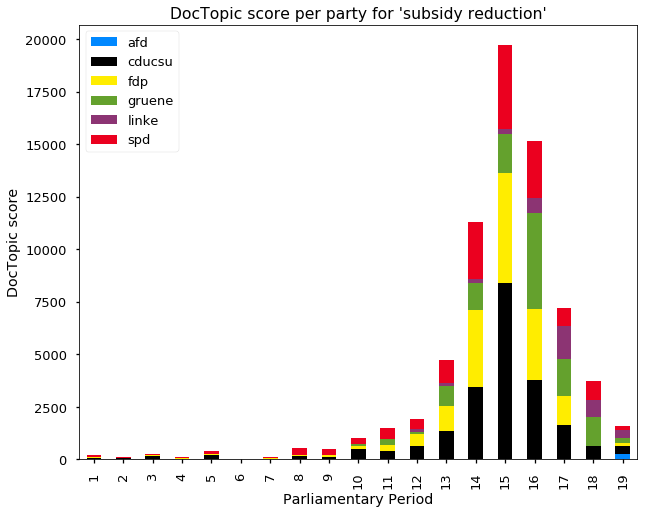

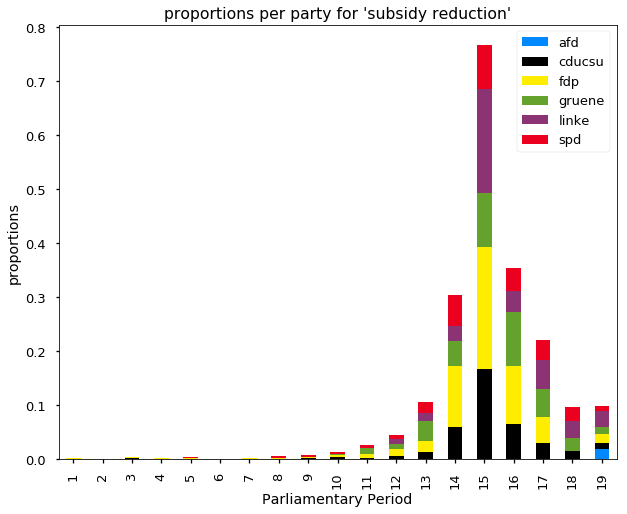

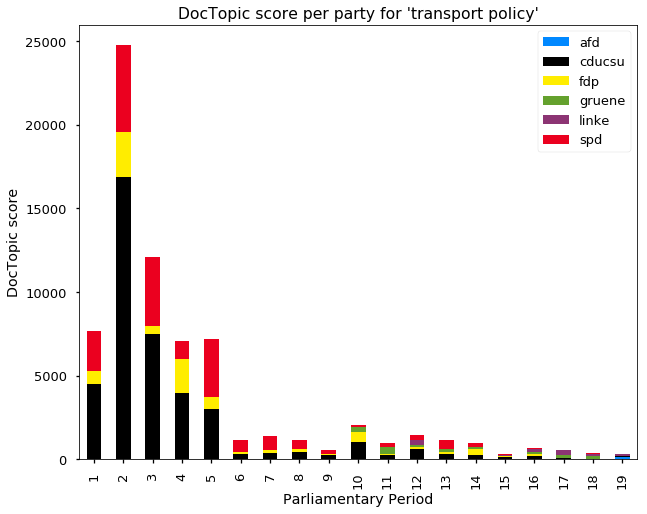

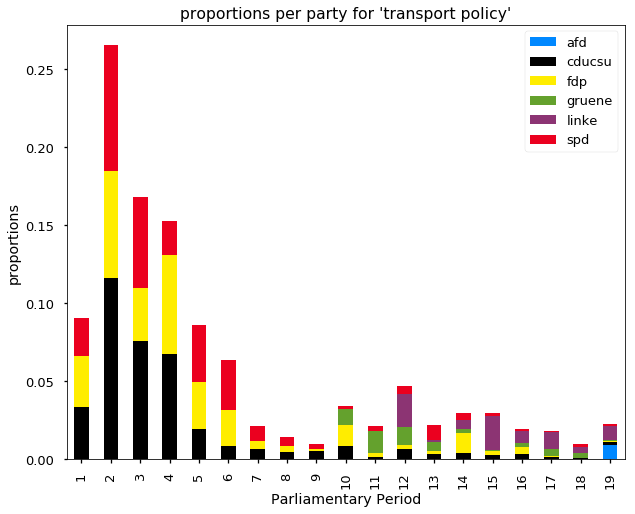

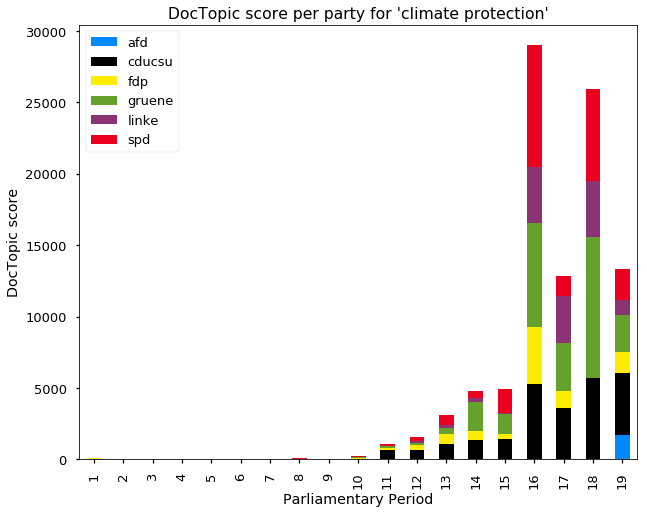

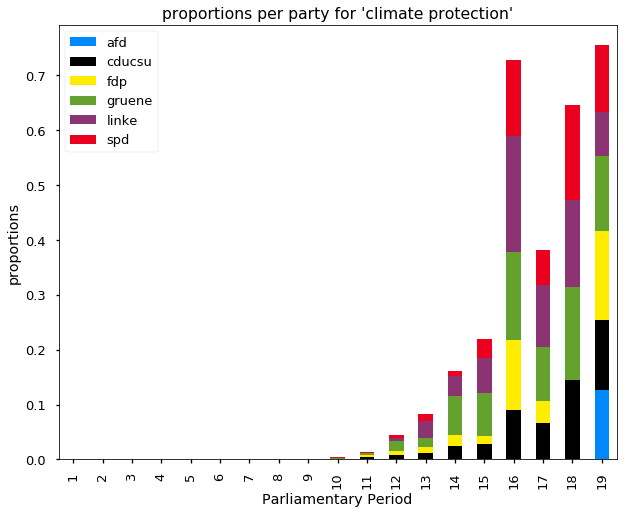

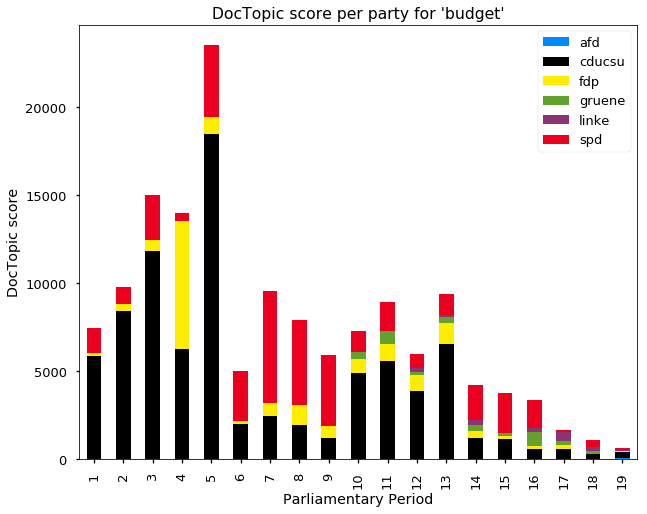

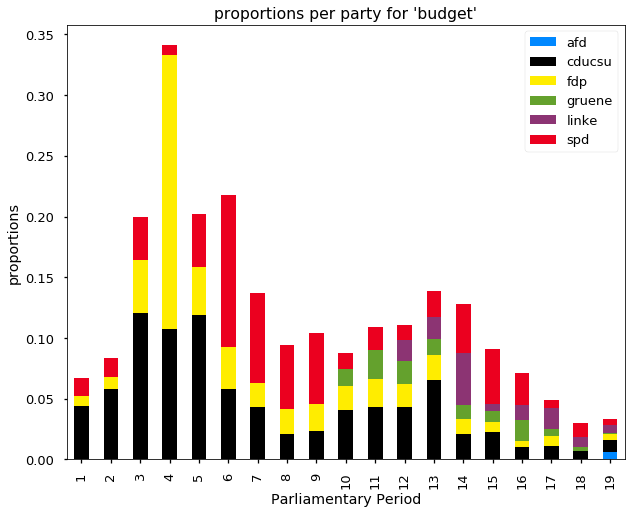

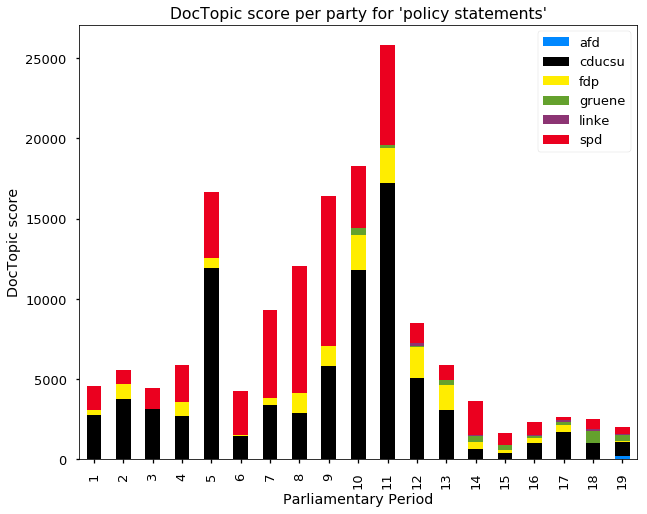

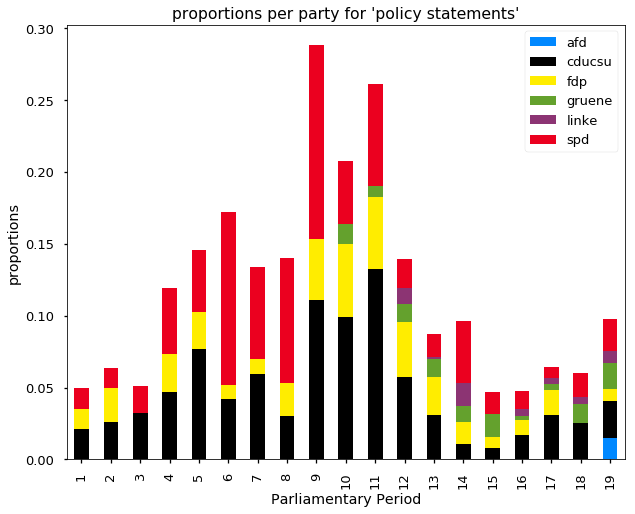

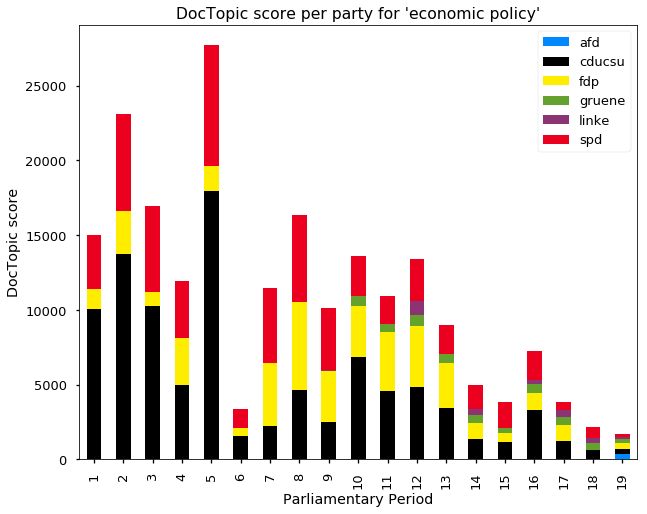

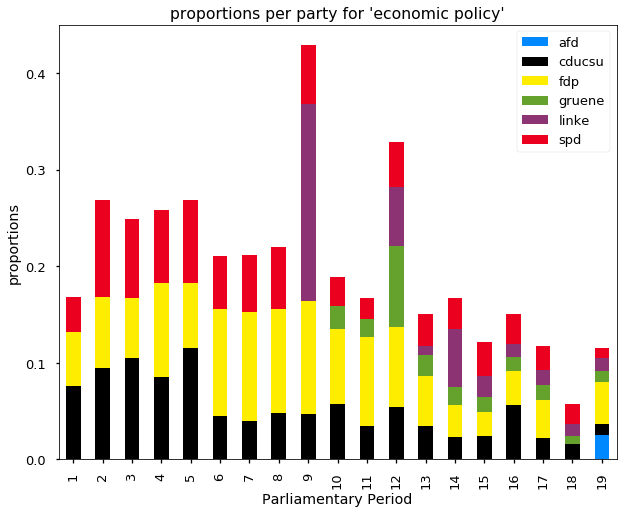

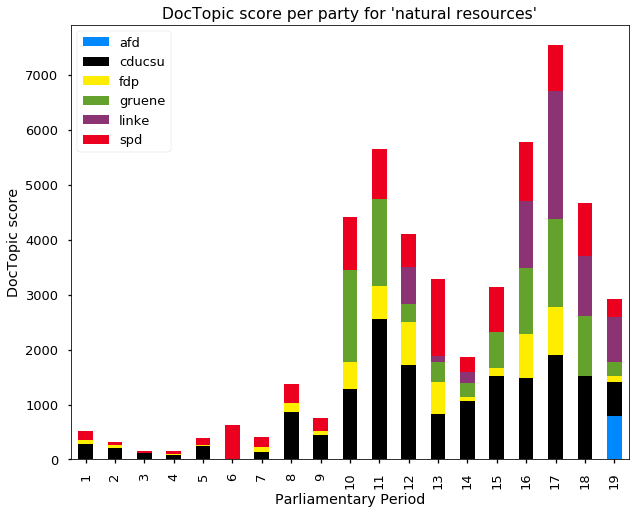

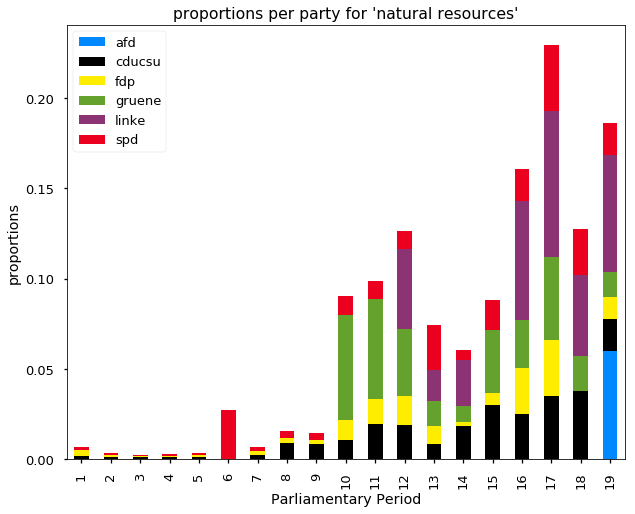

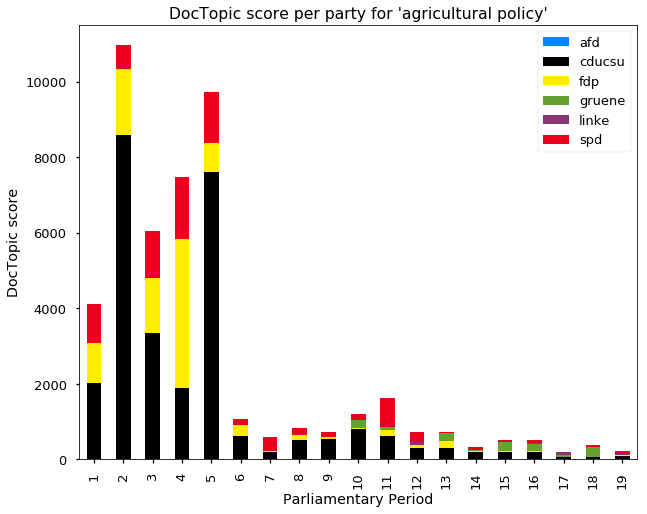

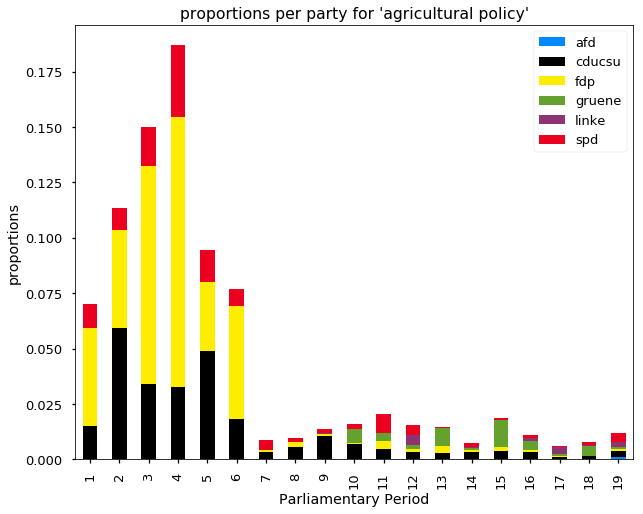

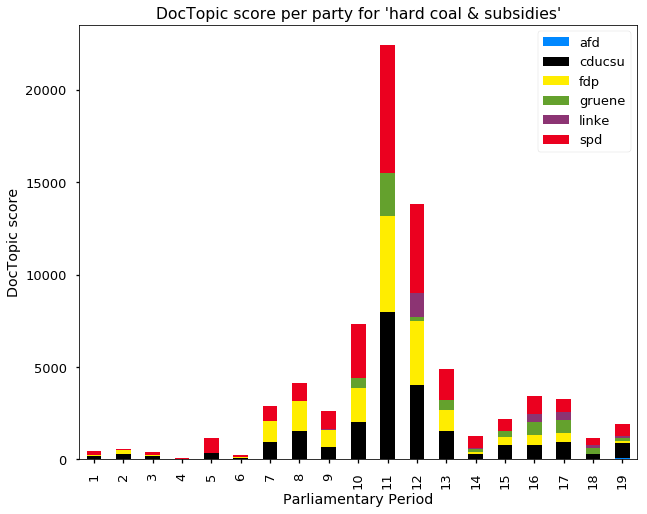

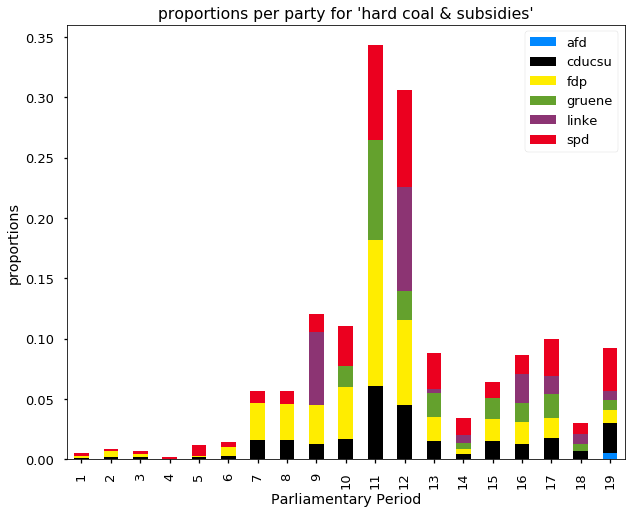

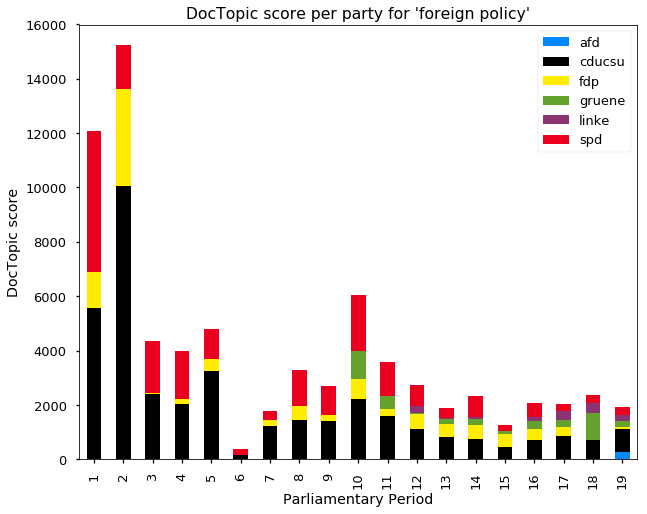

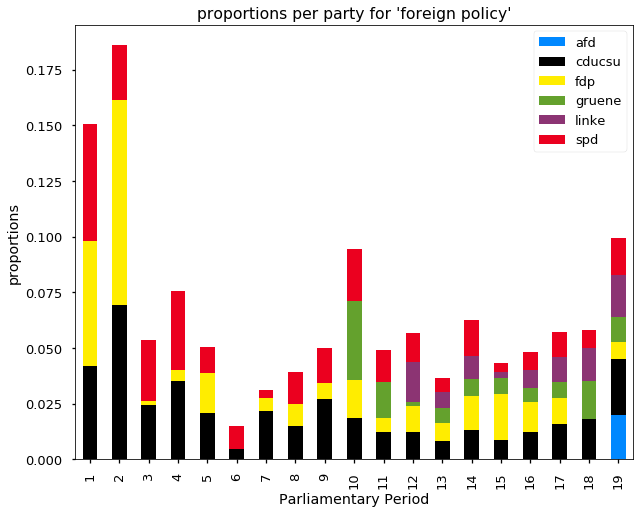

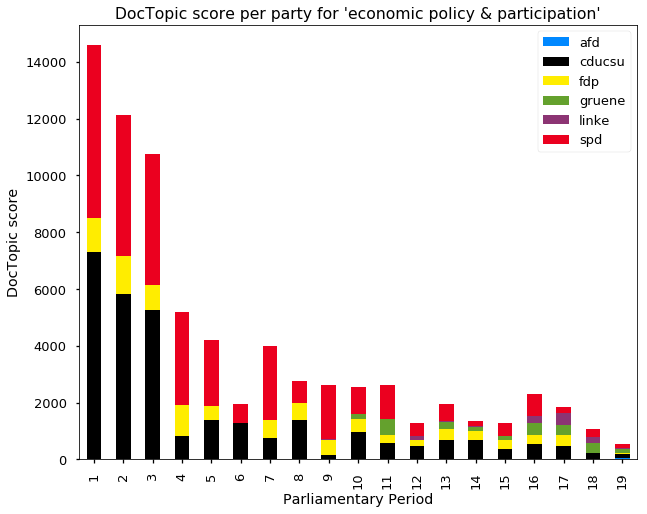

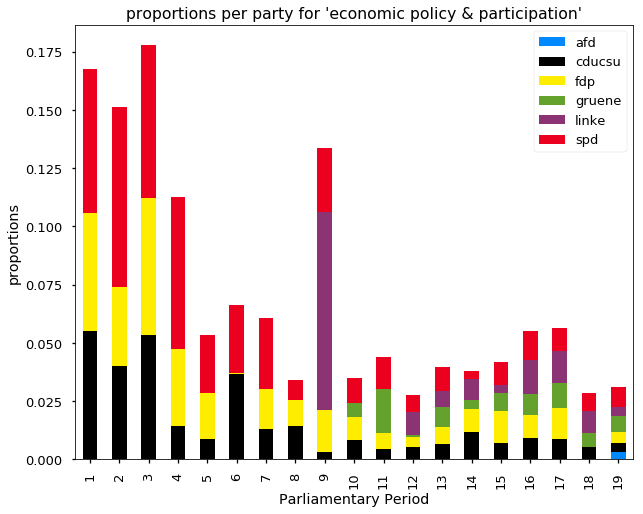

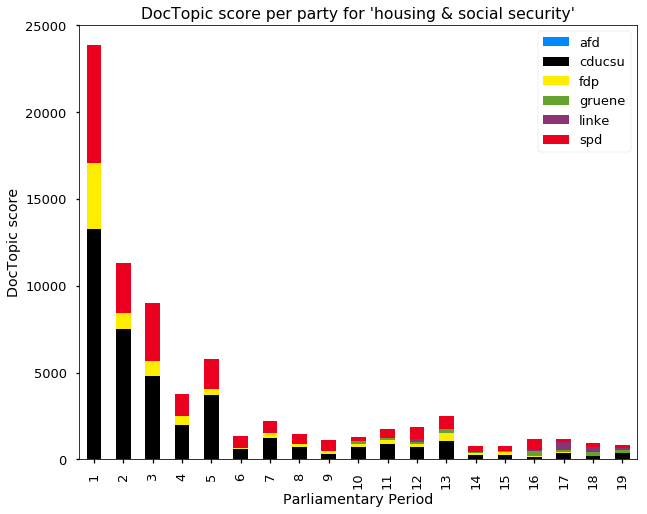

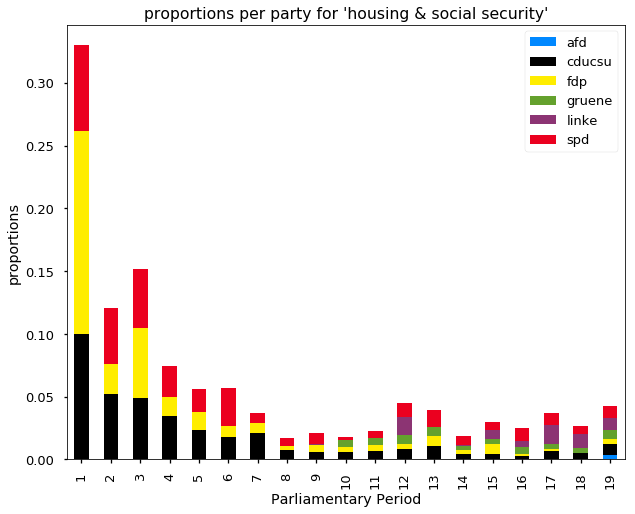

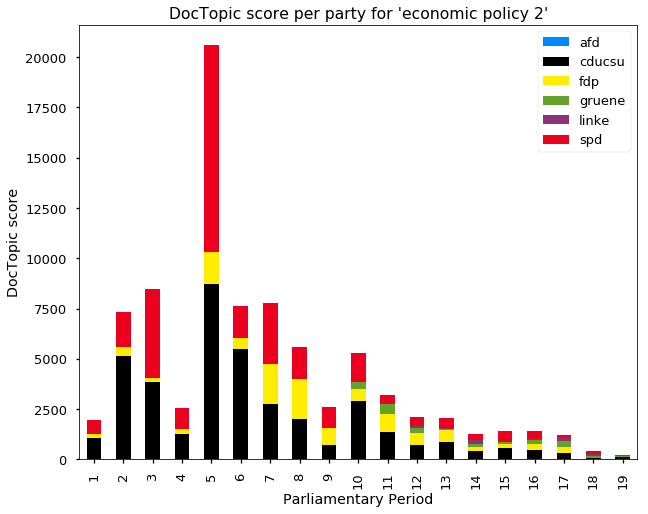

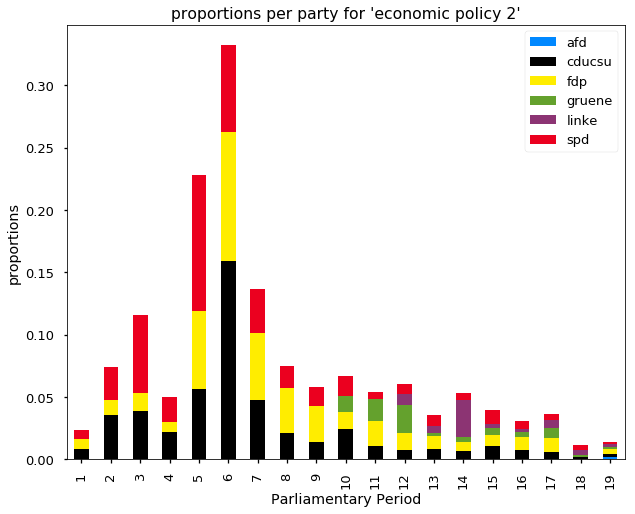

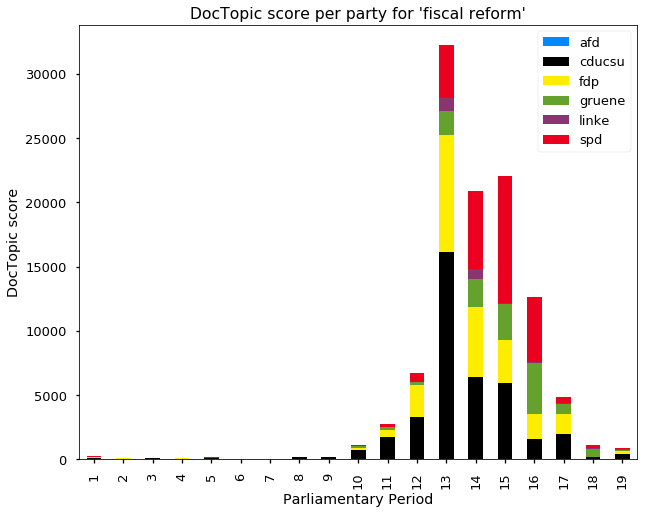

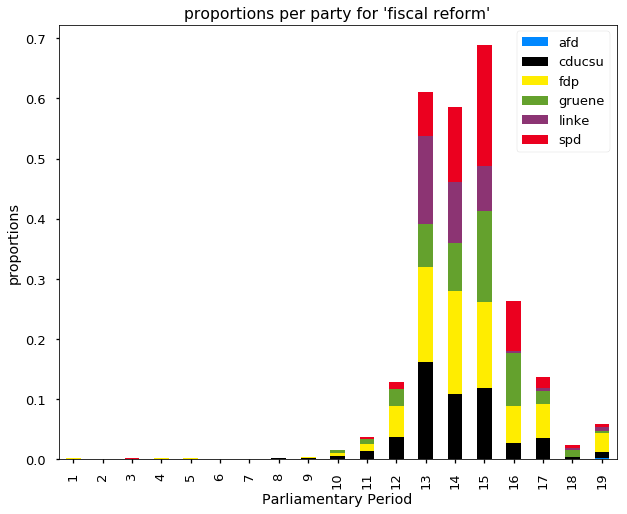

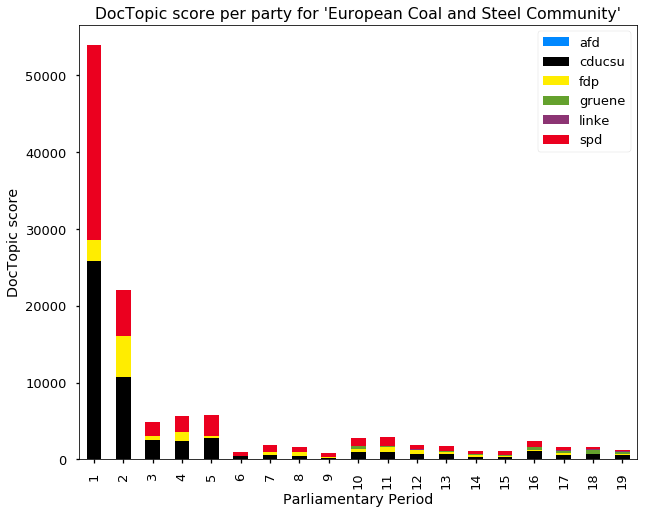

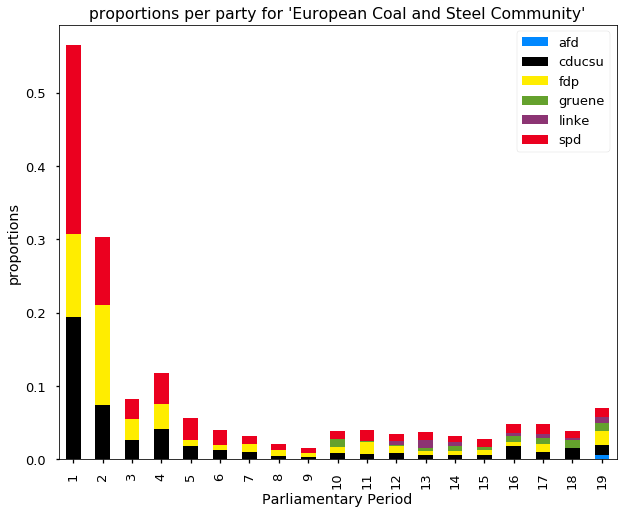

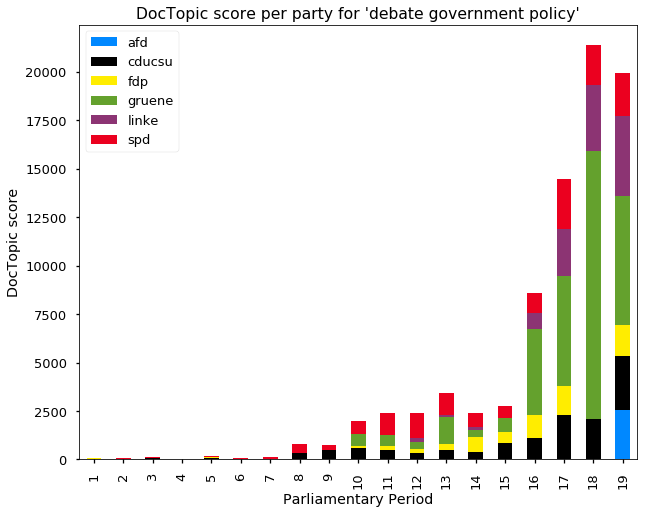

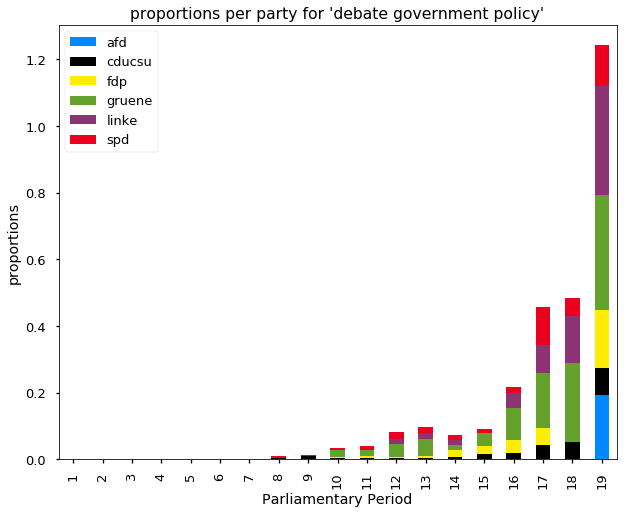

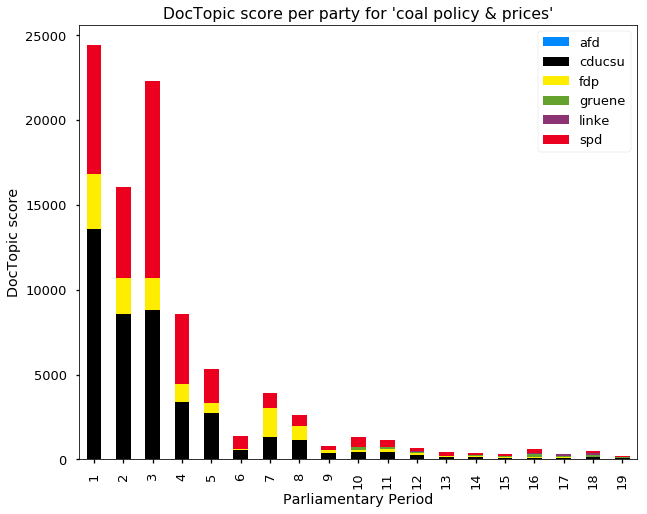

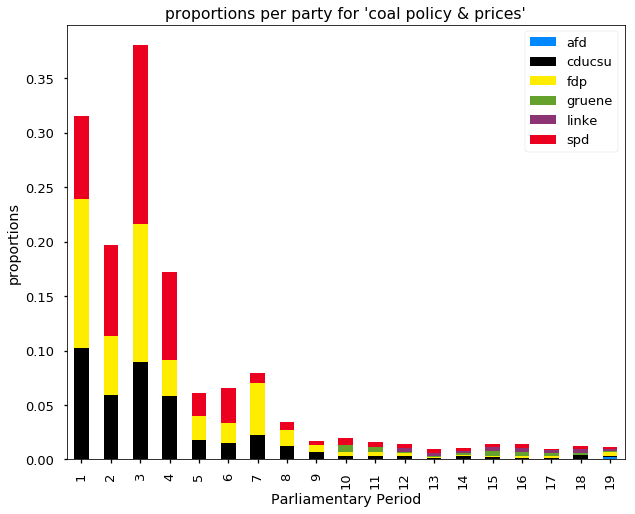

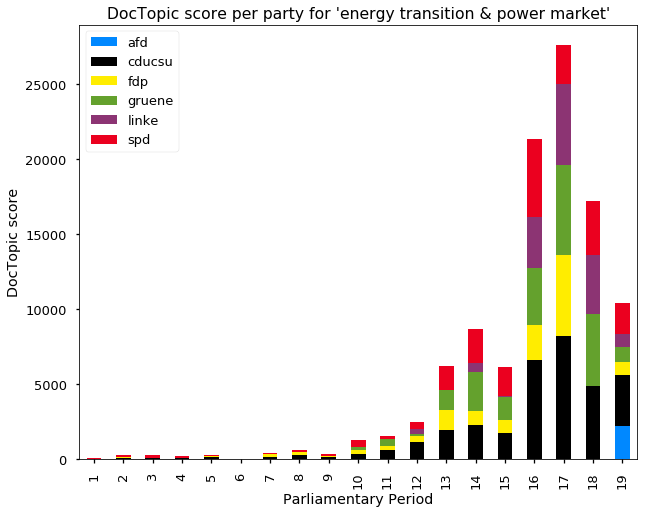

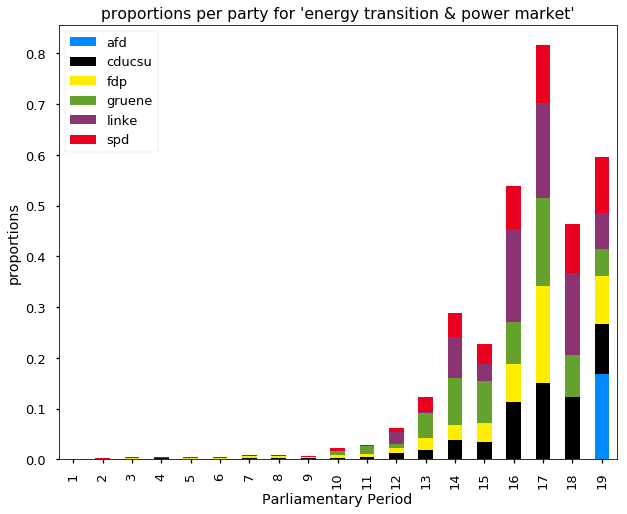

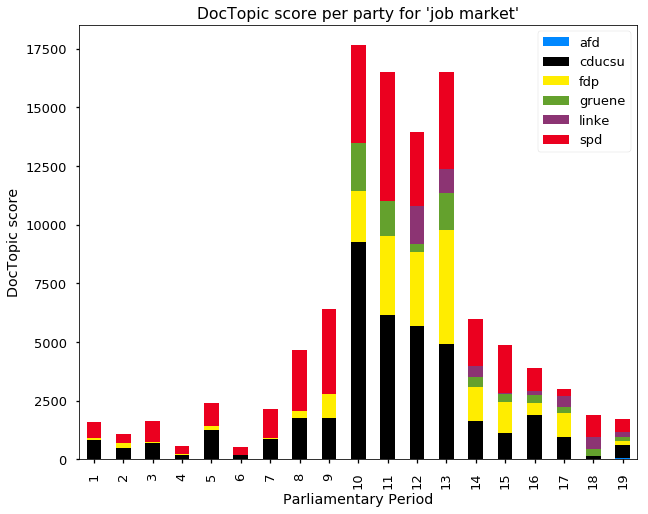

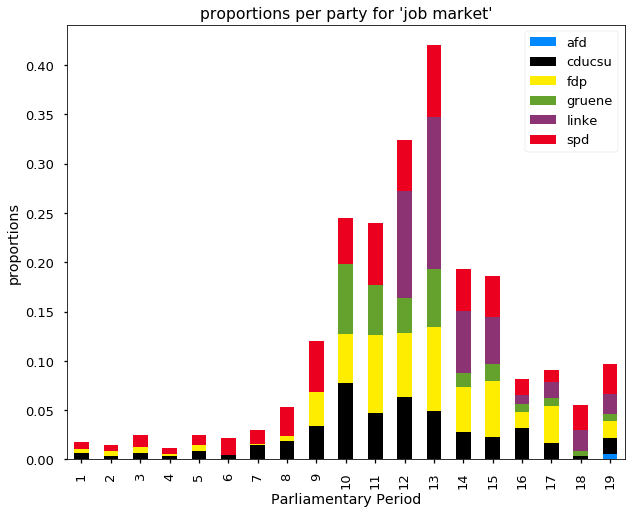

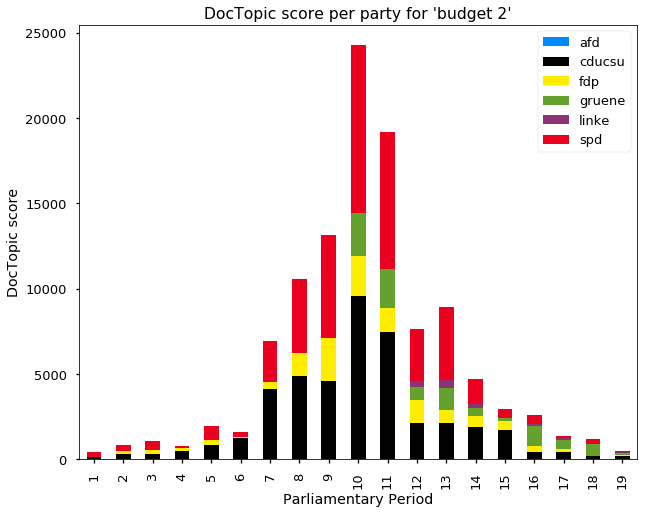

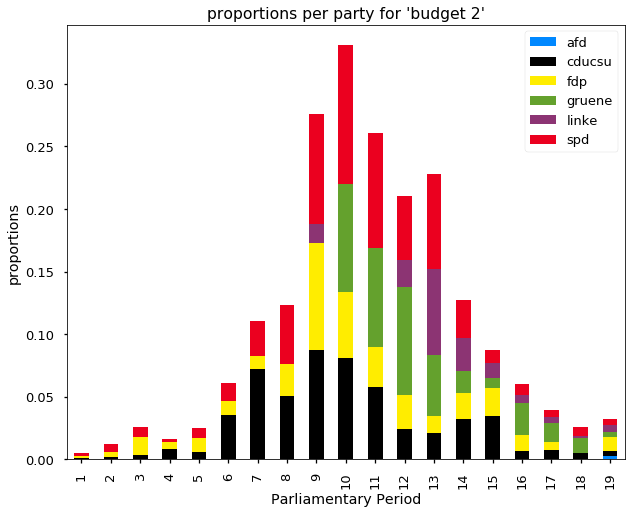

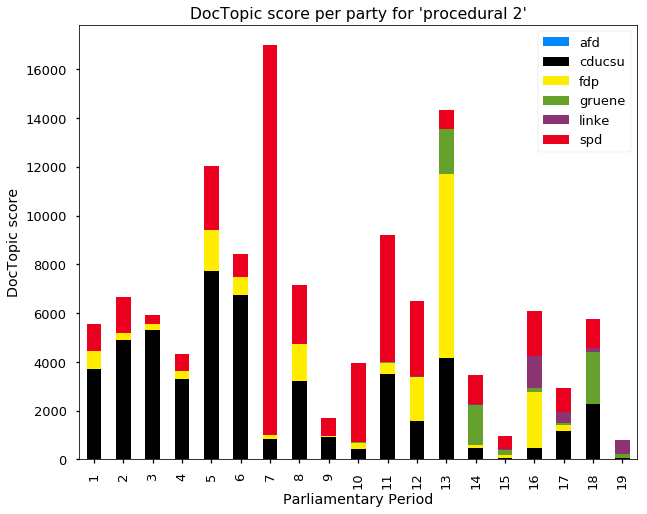

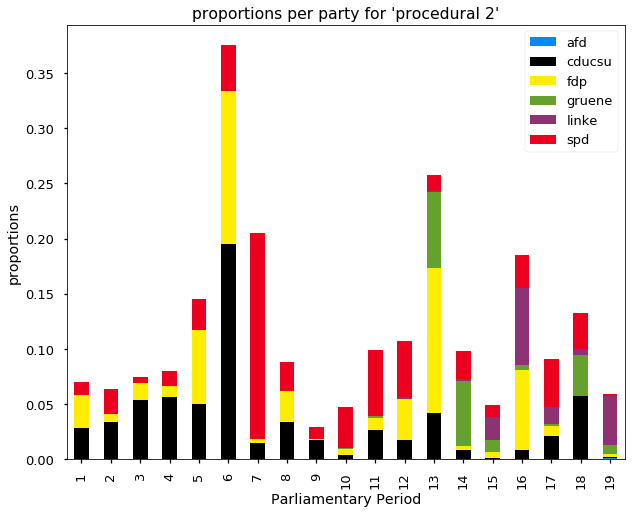

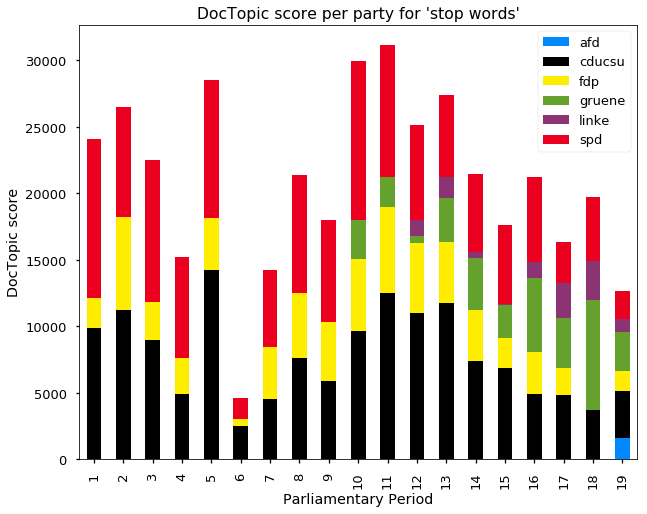

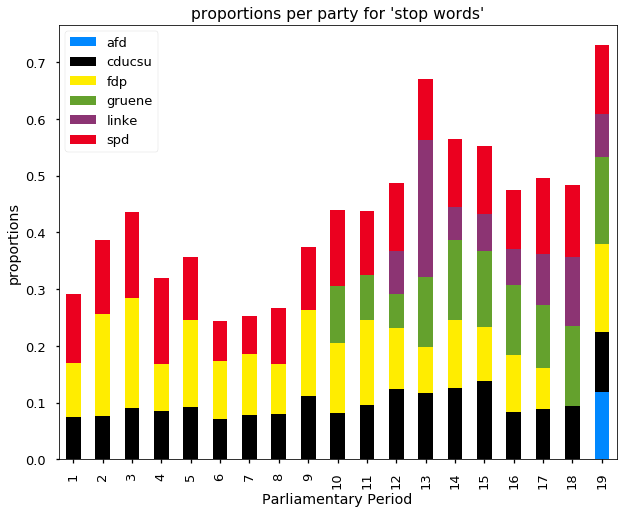

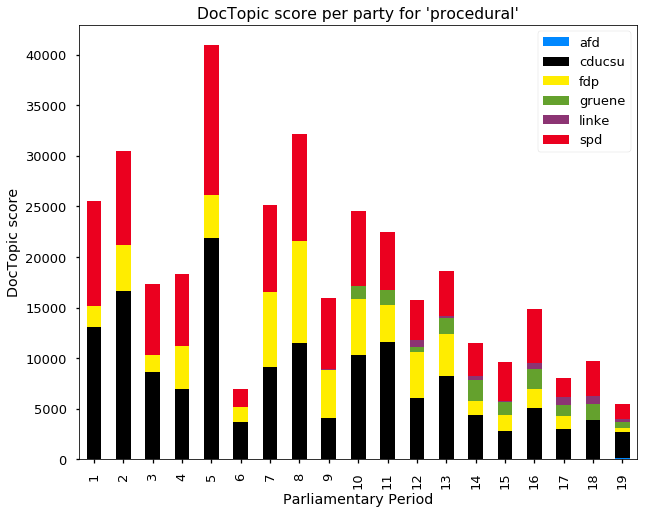

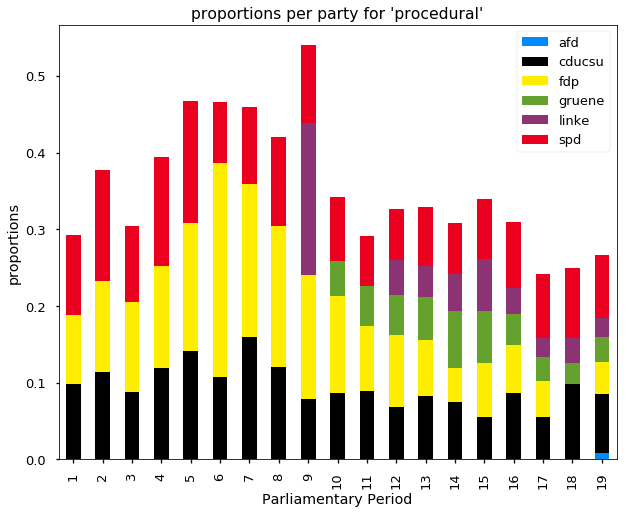

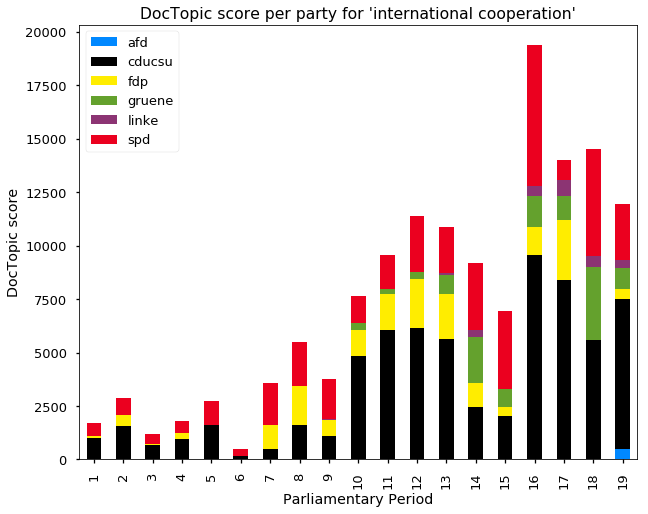

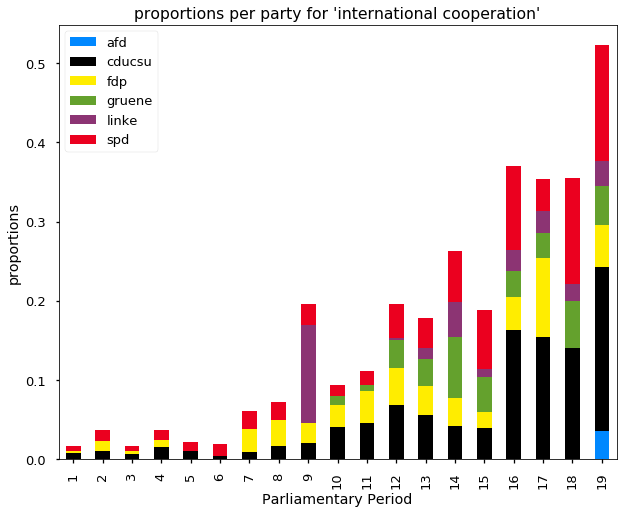

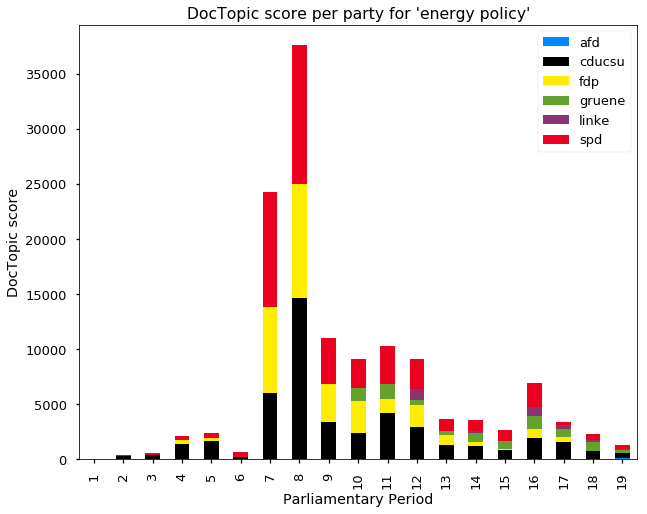

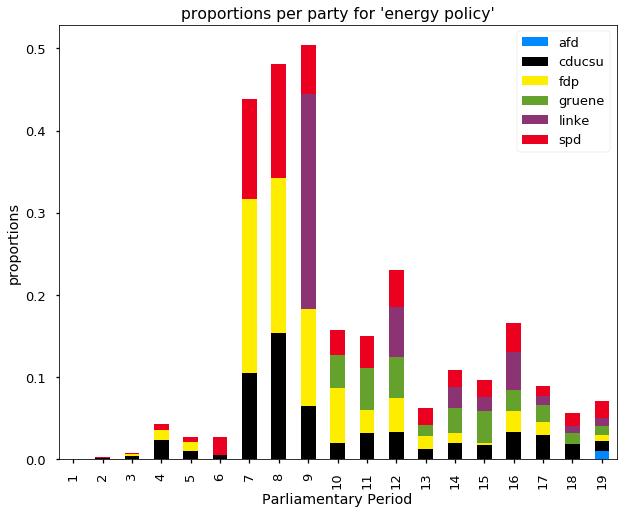

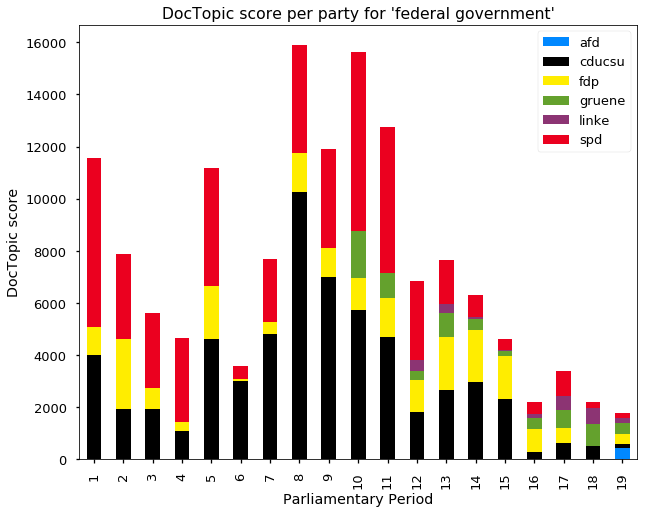

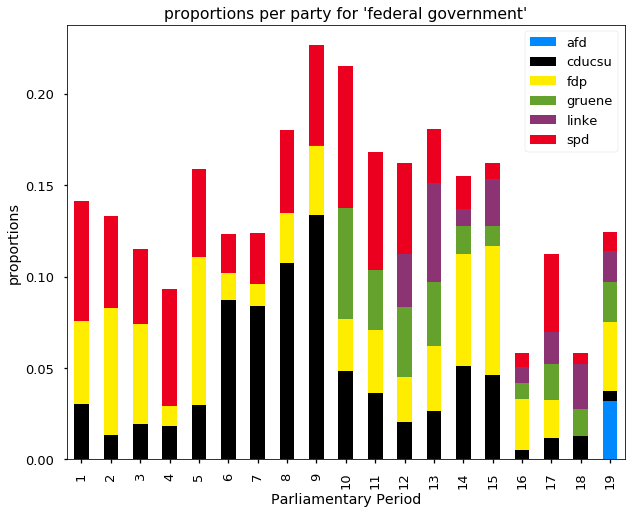

In [6]:
# for ISIE talk:
#topic_id = 167089 # climate policy
#topic_id = 167076 # economy and jobs

topics = Topic.objects.filter(run_id=run_id)

for topic in topics:
    df_scores, df_proportions = get_table_for_party_plots(topic.id)
    topic_label = topic.title
    stacked_bar_plot_party(df_scores, topic_label, filename=os.path.join(save_dir, 'party_scores_run_{}_topic_{}.png'.format(run_id, topic.id)))
    #stacked_bar_plot_party(df_scores, topic_label, pct=True, filename=os.path.join(save_dir, 'party_scores_pct_run_{}_topic_{}.png'.format(run_id, topic.id)))
    stacked_bar_plot_party(df_proportions, topic_label, value_name='proportions', filename=os.path.join(save_dir, 'party_proportions_run_{}_topic_{}.png'.format(run_id, topic.id)))

    del df_scores, df_proportions

# compress folder to easily download it

In [7]:
%%bash
zip -r plots/topic_analysis_2350.zip plots/topic_analysis_2350/

updating: plots/topic_analysis_2350/ (stored 0%)
updating: plots/topic_analysis_2350/0_topic_list_run2350_labeled.csv (deflated 70%)
updating: plots/topic_analysis_2350/0_topic_list+peak_topwords_run2350.xlsx (deflated 5%)
updating: plots/topic_analysis_2350/.ipynb_checkpoints/ (stored 0%)
updating: plots/topic_analysis_2350/topic_evolution_run2350_aggregate.png (deflated 8%)
  adding: plots/topic_analysis_2350/party_proportions_run_2350_selection.png (deflated 30%)
  adding: plots/topic_analysis_2350/topic_evolution_shares_run2350_wo_procedural_barplot_simple.png (deflated 19%)
  adding: plots/topic_analysis_2350/topic_evolution_scores_run2350_all.png (deflated 10%)
  adding: plots/topic_analysis_2350/topic_evolution_shares_run2350_all.png (deflated 9%)
  adding: plots/topic_analysis_2350/time+party/ (stored 0%)
  adding: plots/topic_analysis_2350/time+party/party_scores_run_2350_topic_184087.png (deflated 24%)
  adding: plots/topic_analysis_2350/time+party/party_proportions_run_2350_